In [1]:
# Create an adaptive boosting model to predict tree health classifications.
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

%matplotlib inline

In [2]:
tree_df = pd.read_csv('../data/tree.csv')

In [3]:
# Exploratory data analysis and cleaning.
tree_df.head()

,address,bbl,bin,block_id,boro_ct,borocode,boroname,brch_light,brch_other,brch_shoe,...,trnk_other,trunk_wire,user_type,x_sp,y_sp,zip_city,zipcode,dogs_near_tree,dogs_in_zip_clusters,truncated_zip
0,108-005 70 AVENUE,4.022210e+09,4052307.0,348711,4073900,4,Queens,No,No,No,...,No,No,TreesCount Staff,1027431.148,202756.7687,Forest Hills,11375,1114.0,13781.0,113
1,147-074 7 AVENUE,4.044750e+09,4101931.0,315986,4097300,4,Queens,No,No,No,...,No,No,TreesCount Staff,1034455.701,228644.8374,Whitestone,11357,724.0,13781.0,113
2,390 MORGAN AVENUE,3.028870e+09,3338310.0,218365,3044900,3,Brooklyn,No,No,No,...,No,No,Volunteer,1001822.831,200716.8913,Brooklyn,11211,1094.0,29571.0,112
3,1027 GRAND STREET,3.029250e+09,3338342.0,217969,3044900,3,Brooklyn,No,No,No,...,No,No,Volunteer,1002420.358,199244.2531,Brooklyn,11211,1094.0,29571.0,112
4,603 6 STREET,3.010850e+09,3025654.0,223043,3016500,3,Brooklyn,No,No,No,...,No,No,Volunteer,990913.775,182202.4260,Brooklyn,11215,2036.0,29571.0,112


In [4]:
tree_df.isnull().sum()

address                     0
bbl                      9559
bin                      9559
block_id                    0
boro_ct                     0
borocode                    0
boroname                    0
brch_light                  0
brch_other                  0
brch_shoe                   0
cb_num                      0
census_tract             6519
cncldist                    0
council_district         6519
created_at                  0
curb_loc                    0
guards                  31616
health                  31616
latitude                    0
longitude                   0
nta                         0
nta_name                    0
problems                31664
root_grate                  0
root_other                  0
root_stone                  0
sidewalk                31616
spc_common              31619
spc_latin               31619
st_assem                    0
st_senate                   0
state                       0
status                      0
steward   

In [5]:
tree_df.shape

(683788, 48)

In [6]:
tree_df.columns

Index(['address', 'bbl', 'bin', 'block_id', 'boro_ct', 'borocode', 'boroname',
       'brch_light', 'brch_other', 'brch_shoe', 'cb_num', 'census_tract',
       'cncldist', 'council_district', 'created_at', 'curb_loc', 'guards',
       'health', 'latitude', 'longitude', 'nta', 'nta_name', 'problems',
       'root_grate', 'root_other', 'root_stone', 'sidewalk', 'spc_common',
       'spc_latin', 'st_assem', 'st_senate', 'state', 'status', 'steward',
       'stump_diam', 'tree_dbh', 'tree_id', 'trnk_light', 'trnk_other',
       'trunk_wire', 'user_type', 'x_sp', 'y_sp', 'zip_city', 'zipcode',
       'dogs_near_tree', 'dogs_in_zip_clusters', 'truncated_zip'],
      dtype='object')

In [7]:
# Select relevant features for analysis.
specific_cols = ['zipcode', 'dogs_near_tree', 'stump_diam', 'tree_dbh','guards', 'curb_loc', 'health']
df = tree_df[specific_cols]

In [8]:
tree_df['guards'].value_counts()

None       572306
Helpful     51866
Harmful     20252
Unsure       7748
Name: guards, dtype: int64

In [9]:
tree_df['curb_loc'].value_counts()

OnCurb            656896
OffsetFromCurb     26892
Name: curb_loc, dtype: int64

In [10]:
tree_df['status'].value_counts()

Alive    652173
Stump     17654
Dead      13961
Name: status, dtype: int64

In [11]:
# Get tree and stump measurement values.
stump_values = []
tree_values = []

for i in range(len(df['tree_dbh'])):
    
    tree_val = df.loc[i, 'tree_dbh']
    stump_val = df.loc[i, 'stump_diam']

    tree_values.append(tree_val)
    stump_values.append(stump_val)

In [12]:
# Create a new tree diameter column with all tree and stump measurements.
# If the tree_dbh is zero, stump_diam is not. Vice versa also applies.
new_list = []
for i, j in zip(stump_values, tree_values):
    if i == 0:
        new_list.append(j)
    else:
        new_list.append(i)
df['tree_diam'] = new_list

/Users/cbratkovics/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [13]:
df.head(20)

,zipcode,dogs_near_tree,stump_diam,tree_dbh,guards,curb_loc,health,tree_diam
0,11375,1114.0,0,3,None,OnCurb,Fair,3
1,11357,724.0,0,21,None,OnCurb,Fair,21
2,11211,1094.0,0,3,None,OnCurb,Good,3
3,11211,1094.0,0,10,None,OnCurb,Good,10
4,11215,2036.0,0,21,None,OnCurb,Good,21
5,10023,2294.0,0,11,Helpful,OnCurb,Good,11
6,10023,2294.0,0,11,Helpful,OnCurb,Good,11
7,10019,1361.0,0,9,None,OnCurb,Good,9
8,10305,873.0,0,6,None,OnCurb,Good,6
9,11223,671.0,0,21,None,OffsetFromCurb,Fair,21


In [14]:
df.isnull().sum()

zipcode               0
dogs_near_tree     1297
stump_diam            0
tree_dbh              0
guards            31616
curb_loc              0
health            31616
tree_diam             0
dtype: int64

In [15]:
# Fill values where the tree health is null with a value of dead for that tree (data dictionary).
df['health'].fillna('Dead', inplace=True)

/Users/cbratkovics/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [16]:
df.isnull().sum()

zipcode               0
dogs_near_tree     1297
stump_diam            0
tree_dbh              0
guards            31616
curb_loc              0
health                0
tree_diam             0
dtype: int64

In [17]:
df['health'].value_counts()

Good    528850
Fair     96504
Dead     31616
Poor     26818
Name: health, dtype: int64

In [18]:
# Create a dictionary of tree health represented by numerical values.
health_dict = {'Dead': 0, 'Poor': 1, 'Fair': 2, 'Good': 3}

In [19]:
# Overwrite tree health column with numerical values.
df['health'] = df['health'].map(health_dict)

/Users/cbratkovics/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
df.columns

Index(['zipcode', 'dogs_near_tree', 'stump_diam', 'tree_dbh', 'guards',
       'curb_loc', 'health', 'tree_diam'],
      dtype='object')

In [21]:
df['guards'].value_counts()

None       572306
Helpful     51866
Harmful     20252
Unsure       7748
Name: guards, dtype: int64

In [22]:
df['curb_loc'].value_counts()

OnCurb            656896
OffsetFromCurb     26892
Name: curb_loc, dtype: int64

In [23]:
# Create dummy variables of categorical columns to use as features.
df = pd.get_dummies(df, columns = ['guards', 'curb_loc'], drop_first = True)

In [24]:
# Examine first 5 rows.
df.head()

,zipcode,dogs_near_tree,stump_diam,tree_dbh,health,tree_diam,guards_Helpful,guards_None,guards_Unsure,curb_loc_OnCurb
0,11375,1114.0,0,3,2,3,0,1,0,1
1,11357,724.0,0,21,2,21,0,1,0,1
2,11211,1094.0,0,3,3,3,0,1,0,1
3,11211,1094.0,0,10,3,10,0,1,0,1
4,11215,2036.0,0,21,3,21,0,1,0,1


In [25]:
# Check null values.
df.isnull().sum()

zipcode               0
dogs_near_tree     1297
stump_diam            0
tree_dbh              0
health                0
tree_diam             0
guards_Helpful        0
guards_None           0
guards_Unsure         0
curb_loc_OnCurb       0
dtype: int64

In [26]:
# Drop null values before model building.
df.dropna(inplace=True)

In [27]:
# Create target variable y (income) and predictor matrix X.
features = [col for col in df.columns if col not in ('zipcode', 'health', 'tree_dbh', 'stump_diam')]
X = df[features]
y = df['health']

In [28]:
# Preview features.
features

['dogs_near_tree',
 'tree_diam',
 'guards_Helpful',
 'guards_None',
 'guards_Unsure',
 'curb_loc_OnCurb']

In [29]:
# Train-test split to separate data into a training set and a holdout set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [30]:
# Instantiate and fit adaboost classification model.
ada = AdaBoostClassifier()
ada_model = ada.fit(X_train, y_train)

In [31]:
# AdaBoost training f1-score and accuracy score
train_preds = ada_model.predict(X_train)
train_f1_score = f1_score(y_train, train_preds, average='micro')
train_accuracy_score = accuracy_score(y_train, train_preds)

# AdaBoost testing f1-score and accuracy score
test_preds = ada_model.predict(X_test)
test_f1_score = f1_score(y_test, test_preds, average='micro')
test_accuracy_score = accuracy_score(y_test, test_preds)

In [32]:
# Display f1-score and accuracy score evaluation metrics.
print('AdaBoost Training f1-score = ' , train_f1_score)
print('AdaBoost Testing f1-score = ' , test_f1_score)
print()
print('AdaBoost Training accuracy score = ' , train_accuracy_score)
print('AdaBoost Testing accuracy score = ' , test_accuracy_score)

AdaBoost Training f1-score =  0.8020016879351708
AdaBoost Testing f1-score =  0.8020665443697509

AdaBoost Training accuracy score =  0.8020016879351708
AdaBoost Testing accuracy score =  0.8020665443697509


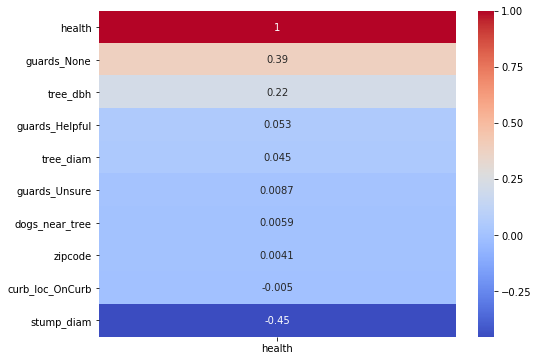

In [33]:
# Seaborn heatmap to determine strength of relationships between tree health and predictive features.
plt.figure(figsize = (8,6))
sns.heatmap(df.corr()[['health']].sort_values('health',ascending=False), annot=True, cmap='coolwarm');
plt.savefig('feature_heatmap.png')

In [34]:
# Examine importance of features:
# [licensed dogs in the area, tree diameter, guards exist, no guards, unsure if guards exist, location on curb]
ada_model.feature_importances_

array([0.46, 0.26, 0.02, 0.24, 0.02, 0.  ])

In [35]:
# Examine model parameters.
ada_model.get_params

<bound method BaseEstimator.get_params of AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)>

In [36]:
# Examine base estimator; decision tree classifier.
ada_model.base_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [37]:
# Examine errors of model estimators:
ada_model.estimator_errors_

array([0.22677917, 0.6258016 , 0.66370712, 0.6565628 , 0.67334375,
       0.68138376, 0.70378432, 0.68328823, 0.69146858, 0.70245303,
       0.69770951, 0.69291287, 0.68613366, 0.70801837, 0.70446132,
       0.70923227, 0.69817581, 0.69736523, 0.7214365 , 0.71554538,
       0.71468461, 0.69985917, 0.71313693, 0.72001386, 0.71086639,
       0.70957202, 0.71743668, 0.71739341, 0.72300905, 0.7246522 ,
       0.71662733, 0.71467161, 0.72119387, 0.72866168, 0.73204112,
       0.73453641, 0.7200874 , 0.73450917, 0.74086181, 0.73481235,
       0.73035517, 0.73387787, 0.73447944, 0.73609127, 0.72989622,
       0.72228269, 0.7272495 , 0.73369598, 0.74242309, 0.73900526])

In [38]:
# Examine weights of model estimators.
ada_model.estimator_weights_

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [39]:
# Examine probability predictions of each of the 4 classes.
# Dead, Poor, Fair, Good -> respective probabilities
ada_model.predict_proba(X)

array([[0.18564252, 0.26593312, 0.27013845, 0.27828591],
       [0.18732955, 0.26092507, 0.27066161, 0.28108376],
       [0.18564252, 0.26593312, 0.27013845, 0.27828591],
       ...,
       [0.18203502, 0.2652061 , 0.27213125, 0.28062763],
       [0.18471586, 0.26441553, 0.27089864, 0.27996998],
       [0.18732955, 0.26092507, 0.27066161, 0.28108376]])

In [40]:
# Examine model estimators; decision tree classifiers.
ada_model.estimators_

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=1483247818, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=894118648, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_le